In [9]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [10]:
import warnings
warnings.filterwarnings('ignore', 'The behavior of `series.*`', FutureWarning)
warnings.filterwarnings('ignore', 'invalid value encountered', RuntimeWarning)


In [11]:
import pandas as pd
import numpy as np
import talib as ta
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from datetime import datetime
from ta import add_all_ta_features
import matplotlib.pyplot as plt

In [27]:

df = pd.read_csv(
        r'C:\Users\MrBios\Documents\Development\test\csv\Featured_bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv',
)
a=df


In [47]:
# Add technical indicator features
# df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)


In [96]:
df=a

In [97]:
# Prepare the data
# drop timestamp column
df = df.drop(columns=['Timestamp'])
# take the last 500 000 rows
df = df.iloc[-500000:]
data = df[['Open', 'High', 'Low', 'Close', 'Volume'] + df.columns[5:].tolist()]  # Select relevant columns
target_col = 'Close'  # Choose the target column to predict
target_data = data[target_col].shift(-30)  # Shift the target data 30 rows into the future
data = data.iloc[:-30]  # Remove the last 30 rows from the input data
# print numbers of features
print(f'Number of features: {len(data.columns)}')

Number of features: 91


In [98]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)


In [99]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_data, target_data[:-30], test_size=0.2, random_state=42)

# Reshape the input data for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [100]:

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(399976, 1, 91) (399976,) (99994, 1, 91) (99994,)


In [101]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=len(data.columns)))


In [102]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [103]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=256)


Epoch 1/10
1563/1563 [==============================] - 8s 4ms/step - loss: 664450560.0000
Epoch 2/10
1563/1563 [==============================] - 5s 4ms/step - loss: 661901120.0000
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 659402176.0000
Epoch 4/10
1563/1563 [==============================] - 5s 3ms/step - loss: 656914048.0000
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 654432448.0000
Epoch 6/10
1563/1563 [==============================] - 5s 4ms/step - loss: 651963776.0000
Epoch 7/10
1563/1563 [==============================] - 5s 4ms/step - loss: 649493440.0000
Epoch 8/10
1563/1563 [==============================] - 6s 4ms/step - loss: 647037568.0000
Epoch 9/10
1563/1563 [==============================] - 6s 4ms/step - loss: 644585664.0000
Epoch 10/10
1563/1563 [==============================] - 5s 3ms/step - loss: 642140544.0000


In [104]:
model.save('1-v4-model.h5')
model.save_weights('1-v4-weights.h5')
# model.load_weights('v4-weights.h5')
# model.load_model('v4-model.h5')

In [105]:
# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

Train Loss: 640922048.0
Test Loss: 641220864.0


In [106]:
# Make predictions on the last 30 minutes of data
last_30_minutes = df.iloc[-30:]
last_30_minutes = add_all_ta_features(last_30_minutes, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

c:\Users\MrBios\anaconda3\lib\site-packages\ta\wrapper.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{colprefix}volume_adi"] = AccDistIndexIndicator(
c:\Users\MrBios\anaconda3\lib\site-packages\ta\wrapper.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{colprefix}volume_obv"] = OnBalanceVolumeIndicator(
c:\Users\MrBios\anaconda3\lib\site-packages\ta\wrapper.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [107]:
last_30_minutes_data = last_30_minutes[['Open', 'High', 'Low', 'Close', 'Volume'] + last_30_minutes.columns[5:].tolist()]

In [108]:
last_30_minutes_scaled = scaler.transform(last_30_minutes_data)

In [109]:
last_30_minutes_scaled = last_30_minutes_scaled.reshape((1, 30, last_30_minutes_scaled.shape[1]))


In [110]:
last_30_minutes_scaled = last_30_minutes_scaled[:, -1:, :]


In [111]:
predicted_prices = model.predict(last_30_minutes_scaled)
predicted_prices

1/1 [==============================] - 0s 397ms/step


array([[25.36826 , 25.359957, 25.363018, 25.35388 , 25.367607, 25.351868,
        25.367117, 25.390694, 25.343803, 25.373455, 25.376076, 25.384789,
        25.356686, 25.387474, 25.36543 , 25.36959 , 25.370789, 25.377014,
        25.365955, 25.34269 , 25.388046, 25.362484, 25.378693, 25.374023,
        25.35534 , 25.354698, 25.353775, 25.376606, 25.362865, 25.360395,
        25.38258 , 25.363384, 25.354147, 25.368355, 25.376877, 25.360554,
        25.372517, 25.382498, 25.360168, 25.37178 , 25.355896, 25.359497,
        25.368362, 25.355904, 25.378727, 25.372002, 25.379131, 25.385466,
        25.355698, 25.383228, 25.38335 , 25.349495, 25.376291, 25.378677,
        25.3583  , 25.36439 , 25.377188, 25.368776, 25.379398, 25.373379,
        25.364906, 25.35001 , 25.370779, 25.357964, 25.360369, 25.358028,
        25.369862, 25.356453, 25.371471, 25.38075 , 25.40424 , 25.37694 ,
        25.37867 , 25.364101, 25.367882, 25.353674, 25.354084, 25.344608,
        25.363907, 25.35181 , 25.40351

In [112]:

predicted_prices = scaler.inverse_transform(predicted_prices)

c:\Users\MrBios\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:530: RuntimeWarning: overflow encountered in divide
  X /= self.scale_


In [113]:
print("Predicted prices for the last 30 minutes:")
print(predicted_prices)

Predicted prices for the last 30 minutes:
[[1.4086348e+06 1.4082868e+06 1.4065335e+06 1.4081778e+06 2.7862496e+04
  3.8114150e+06 2.5855602e+06 4.9611237e+01 3.8255612e+06 1.1806851e+16
  8.6321696e+14 1.1018429e+03 1.4049664e+06 2.5387473e+03           inf
  1.4037715e+06 1.4109015e+06 1.3995906e+06 5.5595294e+02 5.4257786e+01
  2.5388046e+01 2.5362484e+01 1.4062244e+06 1.4080940e+06 1.4032145e+06
  1.8063618e+02 2.2570334e+03 2.5376606e+01 2.5362865e+01 1.3984949e+06
  1.4084629e+06 1.4028790e+06 3.9972424e+02 2.5368355e+01 2.2452781e+04
  2.4712265e+02 4.8502762e+04 4.0113223e+04 1.4871496e+04 1.4057864e+06
  1.4030021e+06 1.4044559e+06 1.4025306e+06 6.6656570e+01 6.2987072e+01
  9.9700821e+01 1.9180822e+01 5.4800177e+02 9.4080391e+04 4.8628135e+03
  4.5946489e+03 1.5233192e+03 1.4065845e+06 1.4037209e+06 1.4030765e+06
  1.4003772e+06 2.5377188e+03 2.0774355e+03 2.2088672e+03 2.1472432e+03
  3.2631449e+04 1.4026199e+06 1.4007284e+06 2.4383645e+03 2.4385952e+03
  4.7727412e+03 1.4048

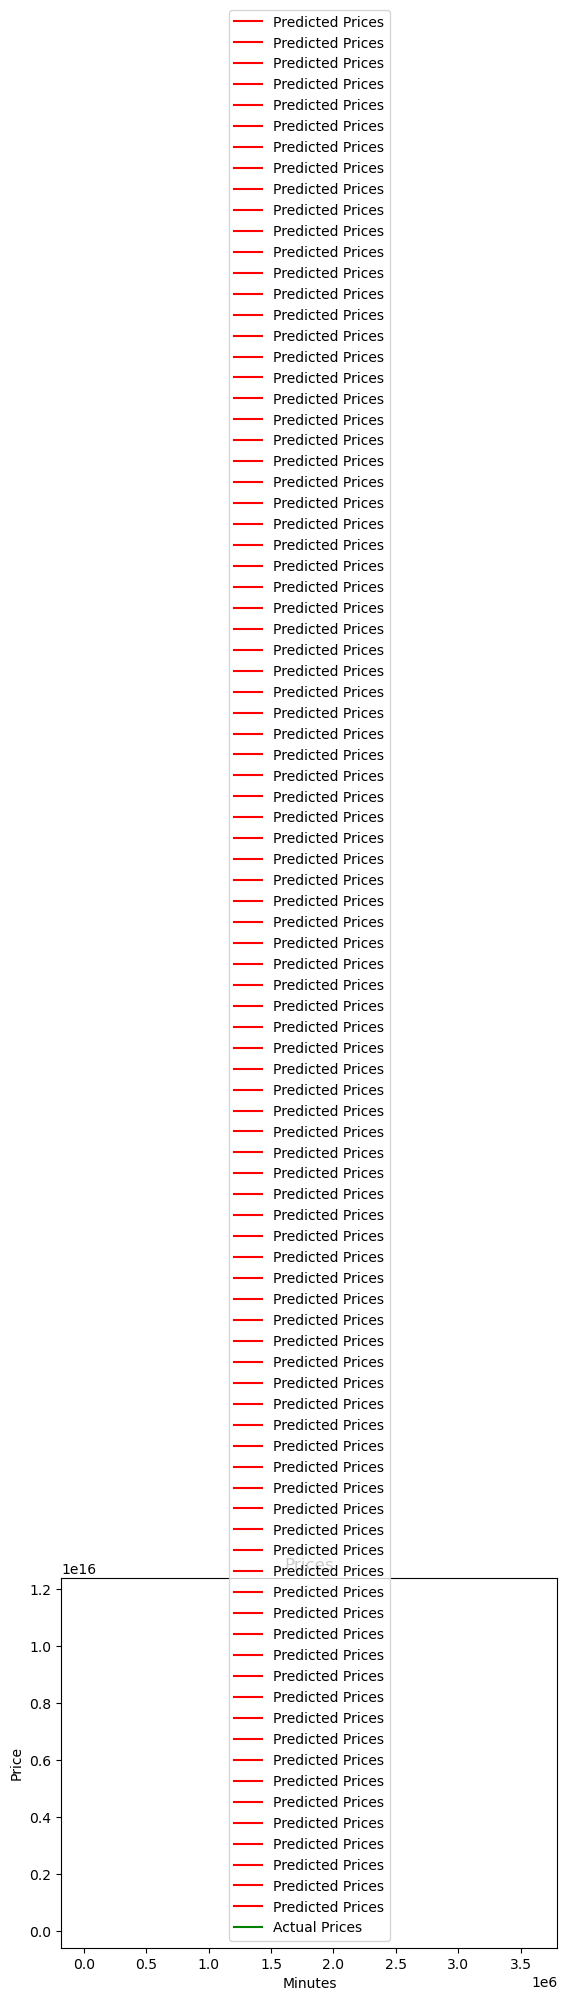

In [114]:
# plot the predicted prices and the actual prices for the last 30 minutes 
plt.plot(predicted_prices, color='red', label='Predicted Prices')
plt.plot(last_30_minutes['Close'], color='green', label='Actual Prices')
plt.title('Prices')
plt.xlabel('Minutes')
plt.ylabel('Price')
plt.legend()
plt.show()
